In [1]:
import numpy as np
import torch
import gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v0")

In [3]:
l1 = 4 #A
l2 = 150
l3 = 2 #B

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) #C
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) #G
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
state2, reward, done, info = env.step(action) #I

In [11]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #A
    disc_return /= disc_return.max() #B
    return disc_return

In [5]:
def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds))

In [14]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(MAX_DUR): #C
        act_prob = model(torch.from_numpy(curr_state).float()) #D
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #F
        transitions.append((prev_state, action, t+1)) #G
        if done: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

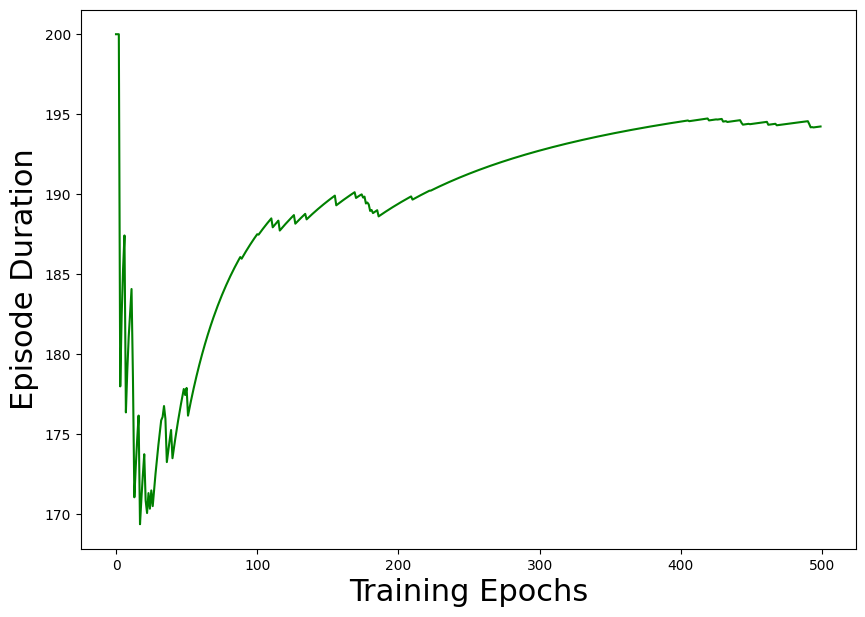

In [15]:
avg_score = [np.sum(np.array(score[0:i]))/i for i in range(1, len(score) + 1)]

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')